<h1><div align="center">Social Data Mining</div></h1>
<h2><div align="center">Lesson II - Networks</div></h2>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.data4sci.com/">www.data4sci.com</a></div>
<div align="center">@bgoncalves, @data4sci</div>

In [1]:
from collections import Counter
import json

import numpy as np
import matplotlib.pyplot as plt
import networkx as NX
import requests

import watermark

%load_ext watermark
%matplotlib inline

Let's start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -p numpy,networkx,requests

Thu Sep 05 2019 

CPython 3.7.3
IPython 6.2.1

numpy 1.16.2
networkx 2.2
requests 2.21.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Network Challenge

In [3]:
G = NX.Graph()

In [4]:
G.add_edge('A', 'B')
G.add_edge('A', 'C')
G.add_edge('B', 'C')
G.add_edge('D', 'E')
G.add_edge('E', 'F')
G.add_edge('D', 'F')

In [5]:
components = list(NX.connected_components(G))

In [6]:
print("The first component has nodes", components[0])
print("The second component has nodes", components[1])

The first component has nodes {'A', 'C', 'B'}
The second component has nodes {'F', 'D', 'E'}


# Directed Graphs

In [7]:
url = "http://www.bgoncalves.com/test.json"

In this example, we will load a json file from the internet using requests and extract the edges from there. You can think of this as a simplified version of what you might do while mining graphs from an API

In [31]:
request = requests.get(url)
data = json.loads(request.text)

Now that we have the contents of the JSON file (our API response) we can extract a list of nodes and edges

In [9]:
nodes = set()
edges = []

for user in data:
    name = user["name"]
    
    nodes.add(name)
    
    for friend in user["friends"]:
        nodes.add(friend["name"])
        edges.append((name, friend["name"]))

And finally create our directed graph

In [10]:
G = NX.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

And query some of it's propertie

In [11]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Is Directed?", NX.is_directed(G))

Number of nodes: 28
Number of edges: 21
Is Directed? True


### In/Out Degree

For directed graphs, the in and out degree might differ. In this simple example we have:

In [12]:
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

in_degree and out_degree return a specialized object that represents a view over the graph. Here we convert them to dictionaries for convenience

In [13]:
for user in in_degree.keys():
    print(user, in_degree[user], out_degree[user])

Atkinson Cabrera 1 0
Consuelo Ratliff 1 0
Dorothea Goodman 1 0
Sosa Greer 1 0
Janette Morton 0 3
Sandra Weiss 1 0
Laura Becker 1 0
Trujillo Valenzuela 1 0
Mcintyre Moran 1 0
Cecile Perkins 1 0
Nadine Weber 1 0
Massey Poole 1 0
Giles Golden 0 3
Jody Rivers 1 0
Chase Marshall 1 0
Brock Wyatt 1 0
Bentley Galloway 0 3
Avis Mendez 0 3
Meyer Ewing 0 3
Alexandria Hancock 0 3
Wilma Tyson 0 3
Stokes Shaffer 1 0
Martin Taylor 1 0
Monique Mccall 1 0
Agnes Savage 1 0
Gay Warren 1 0
Cummings Cantrell 1 0
Odessa Wells 1 0


# Model Implementation

The Barabasi Albert model is one of the better known network models, as it was the first to introduce the preferential attachment mechanism as a way of explainig the broad tail distributions observed in empirical networks. Here we implement preferential attachment by simply choosing randomly over the previously added edge endpoints:

In [14]:
def BarabasiAlbert(N=1000000):
        G = NX.Graph()

        nodes = range(N)
        G.add_nodes_from(nodes)

        edges = [0,1,1,2,2,0]

        for node_i in range(3, N):
                pos = np.random.randint(len(edges))
                node_j = edges[pos]

                edges.append(node_i)
                edges.append(node_j)

        edges = zip(nodes, edges[1::2])

        G.add_edges_from(edges)

        return G

To generate an instance of a BA network, we simply do:

In [15]:
net = BarabasiAlbert()

From where we can extract the degree distribution by counting how many nodes have degree k:

In [16]:
degrees = dict(net.degree())
Pk = np.array(sorted(Counter(degrees.values()).items(), key=lambda x:x[0]))

In [17]:
x = np.arange(1, 100).astype('float')
y = 1e6*np.power(x, -3)

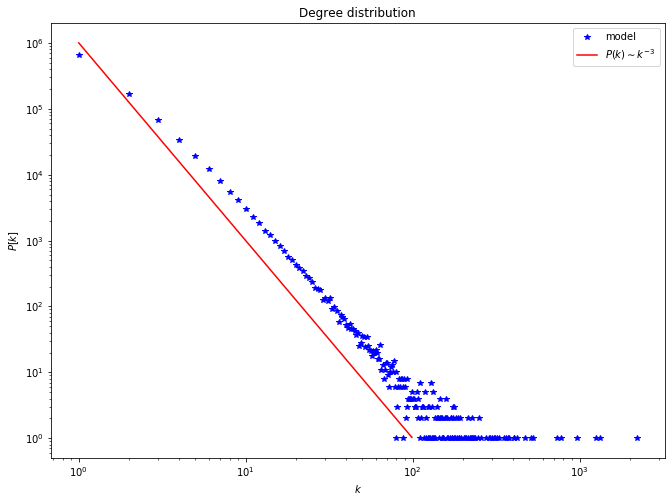

In [18]:
plt.loglog(Pk.T[0], Pk.T[1], 'b*', label='model')
plt.loglog(x, y, 'r-', label='$P(k)\sim k^{-3}$')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$P[k]$')
plt.title('Degree distribution')
plt.gcf().set_size_inches(11, 8)

In [19]:
print("Number of nodes:", net.number_of_nodes())
print("Number of edges:", net.number_of_edges())
print("Is Connected?", NX.is_connected(net))
print("Is Directed?", NX.is_directed(net))

Number of nodes: 1000000
Number of edges: 1000000
Is Connected? True
Is Directed? False


# Network models
Fortunately, NetworkX is able to generate a large number of differnet kinds of graphs so we don't always have to implement them by hand. Typically, the graph generator method name end with "\_graph":

In [20]:
count = 0

for func in NX.__dict__.keys():
    if func.endswith('_graph'):
        doc_string = NX.__dict__[func].__doc__
        
        if doc_string is not None:
            print('%3u NX.%s() -- %s' % (count, func, doc_string.strip().split('\n')[0]))
        else:
            print('%3u NX.%s() -- None' % (count, func))
            
        count += 1

  0 NX.to_networkx_graph() -- Make a NetworkX graph from a known data structure.
  1 NX.barbell_graph() -- Return the Barbell Graph: two complete graphs connected by a path.
  2 NX.complete_graph() -- Return the complete graph `K_n` with n nodes.
  3 NX.complete_multipartite_graph() -- Returns the complete multipartite graph with the specified subset sizes.
  4 NX.circular_ladder_graph() -- Return the circular ladder graph $CL_n$ of length n.
  5 NX.circulant_graph() -- Generates the circulant graph $Ci_n(x_1, x_2, ..., x_m)$ with $n$ vertices.
  6 NX.cycle_graph() -- Return the cycle graph $C_n$ of cyclically connected nodes.
  7 NX.dorogovtsev_goltsev_mendes_graph() -- Return the hierarchically constructed Dorogovtsev-Goltsev-Mendes graph.
  8 NX.empty_graph() -- Return the empty graph with n nodes and zero edges.
  9 NX.ladder_graph() -- Return the Ladder graph of length n.
 10 NX.lollipop_graph() -- Return the Lollipop Graph; `K_m` connected to `P_n`.
 11 NX.null_graph() -- Return 

These can be used easily by simply passing the proper parameters. To get further information about how to use any of them, we can just check out the documentation. For a, say, Watts-Strogats graph, using **NX.connected_watts_strogatz_graph** we have:

In [21]:
help(NX.connected_watts_strogatz_graph)

Help on function connected_watts_strogatz_graph in module networkx.generators.random_graphs:

connected_watts_strogatz_graph(n, k, p, tries=100, seed=None)
    Returns a connected Watts–Strogatz small-world graph.
    
    Attempts to generate a connected graph by repeated generation of
    Watts–Strogatz small-world graphs.  An exception is raised if the maximum
    number of tries is exceeded.
    
    Parameters
    ----------
    n : int
        The number of nodes
    k : int
        Each node is joined with its `k` nearest neighbors in a ring
        topology.
    p : float
        The probability of rewiring each edge
    tries : int
        Number of attempts to generate a connected graph.
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    
    Notes
    -----
    First create a ring over $n$ nodes [1]_.  Then each node in the ring is joined
    to its $k$ nearest neighbors (or 

In [22]:
net = NX.connected_watts_strogatz_graph(100, 4, 0.1)

*NetworkX* also has a wide range of layout algorithms for visualization. For example:

/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/bgoncalves/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


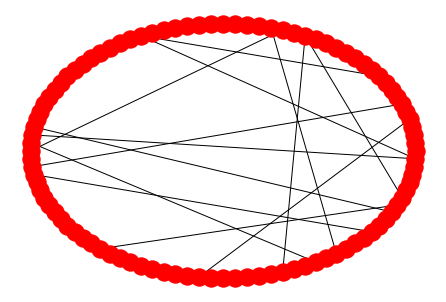

In [23]:
NX.draw_circular(net)

# Snowball Sampling

In [24]:
def snowball(net, seed, max_depth = 3, maxnodes=1000):
    seen = set()
    queue = set()

    queue.add(seed)
    queue2 = set()

    for _ in range(max_depth+1):
        while queue:
            user_id = queue.pop()
            seen.add(user_id)

            NN = net.neighbors(user_id)

            for node in NN:
                if node not in seen:
                    queue2.add(node)

        queue.update(queue2)
        queue2 = set()

    return seen

In [25]:
net = NX.connected_watts_strogatz_graph(100, 4, 0.1)

In [26]:
neve = snowball(net, 0)

In [27]:
print(neve)

{0, 1, 2, 3, 4, 5, 26, 27, 28, 29, 30, 91, 93, 94, 95, 96, 97, 98, 99}


# Challenge Random Walk

To perform a random walk we must just select a neighbor a random at each step

In [28]:
def RandomWalk(net, seed, maxsteps=1000):
    seen = []
    queue = seed
    
    for _ in range(maxsteps+1):
        user_id = queue
        seen.append(user_id)

        NN = list(net.neighbors(user_id))
        
        # Randomly select one of the neighbors
        queue = NN[np.random.randint(len(NN))]

    return seen

In [29]:
random = RandomWalk(net, 0)

We can visualize the path by looking at the position of the "walker" at each timestep

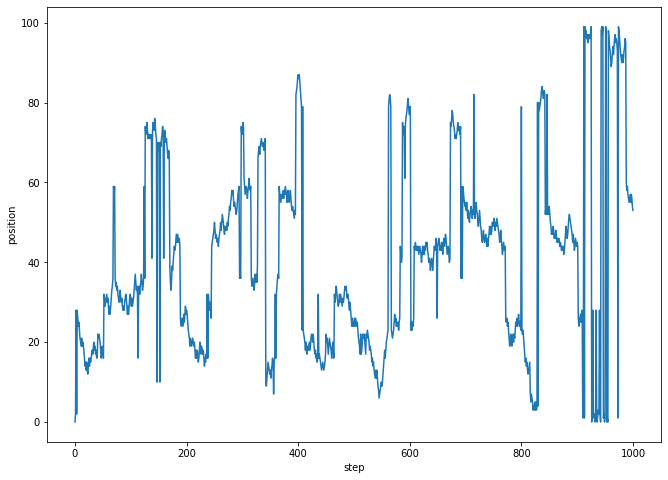

In [30]:
plt.plot(random)
plt.xlabel('step')
plt.ylabel('position')
plt.gcf().set_size_inches(11, 8)

As we cna see, the walker will be "stuck" in a region for a while and then jump to a very differnet location. This happens when it chooses to take one of the long distance jumps that make the Watts Strogatz model famous. It should also be clear that in the random sampling approach there is no limit to the number of times a given node can be visited.